In [45]:
import numpy as np, pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import minimize
import scipy.stats as stats
from matplotlib.ticker import FuncFormatter
import scipy.optimize as op
import os
from nltk import flatten

We implement a function that filters the event times in process j that happens before event time T in process i.

In [46]:
def prev_event(times, T):
    """
    Return the event times in process j that happens before event time T in process i.
    : param times: an n-dimensional array, the full event times in process j
    : param T: a number, one event time in process i
    
    : return k: a number, the index of the last event time in process j happened before T in process i
    """
    
    return np.searchsorted(times, T, side='right')

We will use a dictionary to store the event times in each process before event time T in process i. In this model, we are looking at the departures and arrivals at station i. For a piece of data of event times, we take T as the last event time we observed in departure process at station i.

In [1]:
def process_times_mut(dep_times, arr_times):
    """
    Return the event times in both departure process and arrival process at station i, before the last event time
    observed in departure process.
    
    : param dep_times: a 1-D array, the departure times from station i
    : param arr_times: a 1-D array, the arrival times to station i
    
    : return event_times: a dictionary, storing all relevant event times
    """
    
    event_times = {}
    
    event_times["departure"] = dep_times
    event_times["arrival"] = arr_times[: prev_event(arr_times, dep_times[-1])]
    
    return event_times    

To find the log likelihood function, we first build a function for $B_i(1)$, ..., $B_i(h)$.

In [48]:
def B_i(theta, dep_times, arr_times):
    """
    Finds the array of function B_i, for all event times in process i
    
    : param theta: a 1-D array of length 2, which stores theta and theta'
    : param dep_times, a 1-D array, the event times observed in process i
    : param arr_times, a 1-D array, the event times observed in process j
    
    : return B: a 1D array
    """
    
    B = np.zeros(len(dep_times))
    ind = prev_event(arr_times, dep_times[0])
    
    B[0] = np.sum(np.exp(- theta[1] * (dep_times[0] - arr_times[:ind])))
    
    for h in range(1, len(dep_times)):
        B[h] = np.exp(-theta[1] * (dep_times[h] - dep_times[h-1])) * B[h-1] 
        B[h] += np.sum(np.exp(- theta[1] * (dep_times[h] - arr_times[ind:prev_event(arr_times, dep_times[h])])))
        ind = prev_event(arr_times, dep_times[h])
        
    return B

And the function for $A_i(1)$, ..., $A_i(h)$

In [49]:
def A_i(theta, dep_times):
    """
    Finds the array of function A_i, from 1st event to hth event in process i
    
    : param theta: a 1-D array of length 2, which stores theta and theta'
    : param dep_times, a 1-D array, the event times observed in process i
    
    : return A: a 1-D array
    """
   
    A = np.zeros(len(dep_times))
    
    for h in range(1, len(dep_times)):
        A[h] = np.exp(-theta[0]*(dep_times[h] - dep_times[h-1]))*(1+A[h-1])
        
    return A

The log likelihood function is hence

In [50]:
def mutual_log_likelihood(event_times, beta, theta, lambda_b): 
    """
    Finds the log-likelihood of the mutually exciting process at station i
    
    : param event_times: a dictionary, the event times in all processes \
      that occurred before the last event in process i 
    : param beta: a 1-D array of length 2, which stores beta and beta'
    : param theta: a 1-D array of length 2, which stores theta and theta'
    : param lambda_b: a real number, the baseline intensity of station i
    
    : return res: a real number, the log likelihood
    """
    
    arr_times = event_times["arrival"]
    dep_times = event_times["departure"]
    if len(arr_times) == 0:
        raise Exception("Arrival times null")
    
    ratio = beta/theta
    T = dep_times[-1]
    
    A = A_i(theta, dep_times)
    B = B_i(theta, dep_times, arr_times)
    
    first_sum = np.sum(np.log(lambda_b + beta[0]*A + beta[1]*B))
    second_sum = ratio[0] * np.sum(np.exp(-theta[0]*(T - dep_times)) - 1)
    third_sum = 0
    ind = prev_event(arr_times, T)
    if ind != 0:
        third_sum += ratio[1] * np.sum(np.exp(-theta[1]*(T - arr_times[: ind])) - 1)
    res = first_sum + second_sum + third_sum - lambda_b*T
    
    return res

And the compensator function.

In [51]:
def mutual_comp(t, event_times, beta, theta, lambda_b): 
    
    arr_times = event_times["arrival"]
    dep_times = event_times["departure"]
    if len(arr_times) == 0:
        raise Exception("Arrival times null")
    
    ratio = beta/theta
    
    second_sum = 0
    third_sum = 0
    
    ind_dep = prev_event(dep_times, t)
    if ind_dep != 0:
        second_sum += ratio[0] * np.sum(np.exp(-theta[0]*(t - dep_times[: ind_dep])) - 1)
        
    ind_arr = prev_event(arr_times, t)
    if ind_arr != 0:
        third_sum += ratio[1] * np.sum(np.exp(-theta[1]*(t - arr_times[: ind_arr])) - 1)
    res = lambda_b*t - second_sum - third_sum 
    
    return res

We also need a function to test the log likelihood function.

In [52]:
def mutual_log_likelihood2(event_times, beta, theta, lambda_b): 
    """
    Finds the log-likelihood of the mutually exciting process at station i
    
    : param event_times: a dictionary, the event times in all processes \
      that occurred before the last event in process i 
    : param beta: a 1-D array of length 2, which stores beta and beta'
    : param theta: a 1-D array of length 2, which stores theta and theta'
    : param lambda_b: a real number, the baseline intensity of station i
    
    : return res: a real number, the log likelihood
    """
    
    arr_times = event_times["arrival"]
    dep_times = event_times["departure"]
    
    ratio = beta/theta
    T = dep_times[-1]
    
    A = A_i(theta, dep_times)
    B = B_i(theta, dep_times, arr_times)
    
    first_sum = np.log(lambda_b + beta[0]*A + beta[1]*B)#np.sum(np.log(lambda_b + beta[0]*A + beta[1]*B))
    second_sum = ratio[0] * np.sum(np.exp(-theta[0]*(T - dep_times)) - 1)
    third_sum = 0
    ind = prev_event(arr_times, T)
    if ind != 0:
        third_sum += ratio[1] * np.sum(np.exp(-theta[1]*(T - arr_times[: ind])) - 1)
    res = first_sum + second_sum + third_sum - lambda_b*T
    
    return first_sum, second_sum, third_sum, lambda_b*T

The test

In [53]:
beta = np.array([2.0, 3.0])
theta = np.array([3.0, 4.0])
lambda_b = 1.0
t1 = np.sort(np.random.uniform(0,75,size=3))#np.array([1.0, 2.0, 3.0])
t2 = np.sort(np.random.uniform(0,75,size=3)) #np.array([43.0, 57.0, 62.0])
tdict = {}
tdict['arrival'] = t1
tdict['departure'] = t2


tdict1 = {}
tdict1['arrival'] = t2
tdict1['departure'] = t1
print(mutual_log_likelihood(tdict, beta, theta, lambda_b));
print(mutual_log_likelihood(tdict1, beta, theta, lambda_b))

-72.25070533667574
-76.08603827905156


In [54]:
beta = np.array([2.0, 3.0])
theta = np.array([3.0, 4.0])
lambda_b = 1.0

t00 = np.sort(np.random.uniform(0,75,size=3))#np.array([1.0, 2.0, 3.0])
t01 = np.sort(np.random.uniform(0,75,size=3)) #np.array([43.0, 57.0, 62.0])
tdict = process_times(t00, t01)
t1 = tdict['departure']
t2 = tdict['arrival']

sum_1 = []
for i in range(3):
    log_term = lambda_b 
    if i == 1:
        log_term += beta[0]*np.exp(-theta[0]*(t1[1] -t1[0]))
    
    if i == 2:
        log_term += beta[0]*np.exp(-theta[0]*(t1[2] -t1[0])) + beta[0]*np.exp(-theta[0]*(t1[2] -t1[1]))
    
    ind = np.searchsorted(t2, t1[i], side='right')
    for j in range(ind):
        log_term += beta[1]*np.exp(-theta[1]*(t1[i] -t2[j]))
    
    sum_1.append(np.log(log_term))

sum_2, sum_3 = 0.0, 0.0
for i in range(3):
    sum_2 += np.exp(-theta[0]*(t1[-1]-t1[i]))-1
    
index = np.searchsorted(t2, t1[-1], side="Right")
for m in range(index):
    sum_3 += np.exp(-theta[1]*(t1[-1]-t2[m]))-1

l = np.sum(sum_1) - lambda_b * t1[-1] + beta[0]/theta[0] * sum_2 + beta[1]/theta[1] * sum_3

u = mutual_log_likelihood2(tdict, beta, theta, lambda_b)
#comp, sum1, sum2 = mutual_comp(t1[-1], tdict, beta, theta, lambda_b)
print(np.abs(l - mutual_log_likelihood(tdict, beta, theta, lambda_b)));
print(t1, t2);
print(u[1]-sum1, u[2]-sum2);
print(np.sum(u[0]) - comp - mutual_log_likelihood(tdict, beta, theta, lambda_b))

TypeError: cannot unpack non-iterable numpy.float64 object

In [55]:
print(u[0] - sum_1, 
u[1] - beta[0]/theta[0] * sum_2,
u[2] - beta[1]/theta[1] * sum_3, 
u[3] - lambda_b * t1[-1])


[0. 0. 0.] 0.0 0.0 0.0


We read the arrival times and departure times at station 2, create a dictionary, store the file name as key and the data frame inside the file as value.

In [74]:
path_dep = './Departures'
data_files_dep = os.listdir(path_dep)
path_arr = './Arrivals'
data_files_arr = os.listdir(path_arr)
n_weeks = len(data_files_dep)

bike_dep = {file: pd.read_csv(path_dep + '/' + file)
             for file in data_files_dep}  
bike_arr = {file: pd.read_csv(path_arr + '/' + file)
             for file in data_files_arr} 

for names in bike_dep.keys():
    del bike_dep[names]["Unnamed: 0"]
    del bike_arr[names]["Unnamed: 0"]
    
print(list(bike_dep.values())[0].head(10));
print(list(bike_arr.values())[0].head(10))

dict_keys(['235_07Oct2020-13Oct2020.csv', '234_30Sep2020-06Oct2020.csv', '222_08Jul2020-14Jul2020.csv', '227_12Aug2020-18Aug2020.csv', '224_22Jul2020-28Jul2020.csv', '226_05Aug2020-11Aug2020.csv', '232_16Sep2020-22Sep2020.csv', '228_19Aug2020-25Aug2020.csv', '236_14Oct2020-20Oct2020.csv', '221_01Jul2020-07Jul2020.csv', '231_09Sep2020-15Sep2020.csv', '225_29Jul2020-04Aug2020.csv', '223_15Jul2020-21Jul2020.csv', '233_23Sep2020-29Sep2020.csv', '230_02Sep2020-08Sep2020.csv', '229_26Aug2020-01Sep2020.csv'])
   start_loc  end_loc  distance        start_t          end_t   duration
0          2      357  0.062242  929097.170670  929121.763601  24.592931
1          2      187  0.020372  929241.306527  929250.727868   9.421340
2          2      754  0.021562  929241.789019  929250.951567   9.162548
3          2      666  0.011125  929264.592193  929270.294222   5.702028
4          2      247  0.041899  929265.752582  929298.089879  32.337297
5          2      838  0.107736  929281.027876  929312

We extract the departure times and arrival times at station. We need to get away from the file '.DS_Store'.

In [57]:
dep_times = {}
arr_times = {}

for names in bike_dep.keys():
    if names != '.DS_Store':
        df_dep = bike_dep[names]
        df_dep = df_dep['start_t']
        dep_times[names] = df_dep.values.tolist()
        
        df_arr = bike_arr[names]
        df_arr = df_arr['end_t']
        arr_times[names] = df_arr.values.tolist()
        
print(list(dep_times.values())[0][:10]);
print(list(arr_times.values())[0][:10])

dep_times_list = np.array(sorted(flatten(list(dep_times.values())))) 
arr_times_list = np.array(sorted(flatten(list(arr_times.values()))))

print(dep_times_list); 
print(arr_times_list)

[929097.1706696464, 929241.3065271581, 929241.789018932, 929264.5921932765, 929265.7525824378, 929281.0278757443, 929317.1913228914, 929318.9209534816, 929319.9538303384, 929323.356285832]
[929181.3531547785, 929180.656094582, 929215.3870841152, 929253.2432323956, 929275.2044161615, 929283.2932669384, 929283.7339479215, 929287.9630539321, 929312.2128430692, 929321.5759618869]
[787818.00899596 787818.37784005 787819.41979034 ... 948753.68819852
 948754.49673991 948862.00402456]
[787844.92525324 787846.54600157 787847.62746442 ... 948822.41160497
 948858.24121458 948867.90484185]


We test the model on data.

In [58]:
t0 = process_times(dep_times_list, arr_times_list)
mutual_log_likelihood(t0, np.array([2, 2]), np.array([1, 1]), 1)
t1 = process_times(arr_times_list, dep_times_list)
mutual_log_likelihood(t1, np.array([2, 2]), np.array([1, 1]), 1)

-975617.0073080042

We perform the optimisation

In [59]:
op_mutual_log_likelihood = lambda param, t: - mutual_log_likelihood(t, np.array([np.exp(param[0]), np.exp(param[1])]), 
                                                                    np.array([np.exp(param[0])+np.exp(param[2]),np.exp(param[1])+np.exp(param[3])]),
                                                                    np.exp(param[4]))

mle = op.minimize(op_mutual_log_likelihood, x0 = [-4, -11, -8, 25, -9], method = 'Nelder-Mead', args=(t0,))
mle

 final_simplex: (array([[ -4.03811564, -11.01011244,  -8.26061058,  23.97506859,
         -9.09839966],
       [ -4.03811576, -11.01007093,  -8.26061142,  23.97515271,
         -9.09839972],
       [ -4.03811557, -11.01009062,  -8.26061528,  23.97510787,
         -9.09839953],
       [ -4.03811569, -11.01012086,  -8.26061434,  23.97501887,
         -9.09839936],
       [ -4.03811564, -11.0100878 ,  -8.26061192,  23.97512585,
         -9.0983989 ],
       [ -4.03811584, -11.01008442,  -8.26061198,  23.97512565,
         -9.09839982]]), array([26854.68081996, 26854.68081996, 26854.68081996, 26854.68081996,
       26854.68081996, 26854.68081996]))
           fun: 26854.680819962166
       message: 'Optimization terminated successfully.'
          nfev: 197
           nit: 105
        status: 0
       success: True
             x: array([ -4.03811564, -11.01011244,  -8.26061058,  23.97506859,
        -9.09839966])

And we find the p values.

In [70]:
beta_dd, theta_dd, beta_ad, theta_ad, lambda_b = np.exp(mle.x[0]), np.exp(mle.x[1]), np.exp(mle.x[0]) + np.exp(mle.x[2]), np.exp(mle.x[1]) + np.exp(mle.x[3]), np.exp(mle.x[4])
beta = np.array([beta_dd, beta_ad])
theta = np.array([theta_dd, theta_ad])


compensator_t = np.zeros(len(t0)+1)
for i in range(len(t0)):
    compensator_t[i+1] = mutual_comp(t0["departure"][i], t0, beta, theta, lambda_b)

inter_arr_times = np.diff(compensator_t)
p_values = np.exp(-inter_arr_times)

In [71]:
def ecdf(data): # https://cmdlinetips.com/2019/05/empirical-cumulative-distribution-function-ecdf-in-python/
    """ Compute ECDF """
    data = np.sort(data)
    n = data.size
    y = np.arange(1, n+1) / n
    return(data,y)

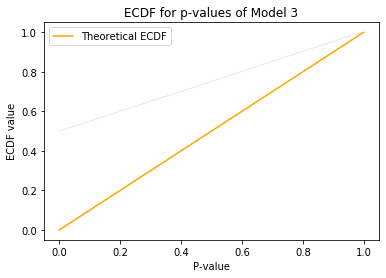

In [72]:
x,y = ecdf(p_values)
plt.plot(x,y, alpha=0.2, linewidth=0.5, color='blue')

plt.title("ECDF for p-values of Model 3")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='orange')
plt.legend()
plt.show()